# Temporarily disable GPU for building on local machine

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Introduction

This example shows how to train a neural network to recognize text in images.  We use Keras's functional API to implement a model based on the CRNN architecture. We also create both a custom loss function to adapt the CTC loss provided by `tensorflow.keras.backend`, as well as a custom metric to adapt `tf.edit_distance`.

To demonstrate this setup, we build a training dataset by generating synthetic images from a source list of words. To implement the dataset, we subclass `tensorflow.keras.utils.Sequence`. It provides an `on_epoch_end` callback, which we use for curriculum learning by gradually ramping up the difficulty of the dataset during training.

## Setup

One external package is required for this example.
* `cairocffi` provides Python bindings for `cairo`, a 2D vector graphics library written in the C programming language. We use this package to generate synthetic images of text.

If you've opened this example in Google Colab, you can install the package like this:

In [1]:
!pip install cairocffi

Then, import the required dependencies:

In [2]:
# TensorFlow packages
from tensorflow.keras import layers, losses, models, optimizers, utils
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
import tensorflow as tf

# Third-party packages
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cairocffi as cairo

## Preparing a synthetic dataset

We train our neural network on a dataset that contains synthetic images. The synthetic images are generated on the fly from a list of source text sequences. The images appear as black printed text on a white background, with image processing to add realistic noise.

> _**Note:** Other text-image datasets can be found in existing OCR research literature. These datasets are often designed for more challenging OCR applications, such as scene text recognition with non-horizontal text. If you plan to adapt this tutorial for your own work, consider using one of the following datasets: [MJSynth (MJ)](http://www.robots.ox.ac.uk/~vgg/data/text/), [SynthText (ST)](http://www.robots.ox.ac.uk/~vgg/data/scenetext/), [IIIT](http://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html), [SVT](http://www.iapr-tc11.org/mediawiki/index.php/The_Street_View_Text_Dataset), [IC03](http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2003_Robust_Reading_Competitions), [IC13](http://rrc.cvc.uab.es/?ch=2), [IC15](http://rrc.cvc.uab.es/?ch=4), [SVTP](http://openaccess.thecvf.com/content_iccv_2013/papers/Phan_Recognizing_Text_with_2013_ICCV_paper.pdf), and/or [CUTE](http://cs-chan.com/downloads_CUTE80_dataset.html)._



### Downloading the source word lists

First, let's download and uncompress an archive containing two text files.

In [3]:
from pathlib import Path

tgz_path = Path(
    utils.get_file('wordlists.tgz',
                   origin='http://www.mythic-ai.com/datasets/wordlists.tgz',
                   untar=True)
)

dataset_dir = tgz_path.parent
monogram_file = dataset_dir / "wordlist_mono_clean.txt"
bigram_file   = dataset_dir / "wordlist_bi_clean.txt"

Each file contains a different set of [**n-gram**](https://en.wikipedia.org/wiki/N-gram) data samples:
* `wordlist_mono_clean.txt` contains a list of **monograms**, or single words. These words have been pre-sorted according to their frequency in English speech.
* `wordlist_bi_clean.txt` contains a list of **bigrams**, or pairs of words.

### Loading and preprocessing words

Before using these word lists to create a dataset, we filter out any unsuitable examples as we load them into memory.

We use 2 criteria for filtering:

* `ABSOLUTE_MAX_STRING_LEN` restricts the length of allowable text sequences.
* `ALPHABET` contains every allowable character. In this example, we attempt to recognize only lowercase alphabetic characters.

We then combine the monograms and bigrams into a single source list of text seqeunces, then sort them based on length.

In [4]:
import re

ABSOLUTE_MAX_STRING_LEN = 16
ALPHABET = u'abcdefghijklmnopqrstuvwxyz '

def preprocess_words(wordlist_file, valid_characters, max_string_len=None):
    def _is_valid_str(in_str):
        search = re.compile(rf'^[{valid_characters} ]+$', re.UNICODE).search
        return bool(search(in_str))

    def _is_length_of_word_valid(word):
        return (max_string_len == -1 or
                max_string_len is None or
                len(word) <= max_string_len)

    valid_words = []
    with wordlist_file.open() as f:
        for line in f:
            word = line.rstrip()
            if _is_valid_str(word) and _is_length_of_word_valid(word):
                valid_words.append(word)

    return valid_words

monograms = preprocess_words(monogram_file, ALPHABET, ABSOLUTE_MAX_STRING_LEN)
bigrams   = preprocess_words(bigram_file, ALPHABET, ABSOLUTE_MAX_STRING_LEN)
sequences = sorted(monograms + bigrams, key=len)

print(f"Wordlists contain {len(sequences)} suitable text sequences.")

Wordlists contain 152494 acceptable text sequences.


### Set aside words for validation

Here, we use a slightly more involved approach (compared to simple Python list indexing) to ensure that words of varying lengths are distributed evenly between the training and validation sets.


In [5]:
VAL_SPLIT = 0.2

def trn_val_split(input_list, split_ratio):
    n = round(1 / split_ratio)
    trn_list, val_list = [], []
    for i, item in enumerate(input_list):
        if i % n == 0:
            val_list.append(item)
        else:
            trn_list.append(item)

    return trn_list, val_list

trn_sequences, val_sequences = trn_val_split(sequences, VAL_SPLIT)

### Defining functions for creating synthetic text images

These functions generate images from strings of text. They include image transformations to introduce variations in the generated images, too. This helps to improve the capacity of the model, and lower the risk of overfitting.

In [6]:
# this creates larger "blotches" of noise which look
# more realistic than just adding gaussian noise
# assumes greyscale with pixels ranging from 0 to 1

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck


# paints the string in a random location the bounding box
# also uses a random font, a slight random rotation,
# and a random amount of speckle noise

def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
    surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
    with cairo.Context(surface) as context:
        context.set_source_rgb(1, 1, 1)  # White
        context.paint()
        if multi_fonts:
            fonts = ['Century Schoolbook', 'Courier', 'STIX', 
                     'URW Chancery L', 'FreeMono']
            context.select_font_face(
                np.random.choice(fonts), 
                cairo.FONT_SLANT_NORMAL,
                np.random.choice([cairo.FONT_WEIGHT_BOLD, 
                                  cairo.FONT_WEIGHT_NORMAL])
            )
        else:
            context.select_font_face('Courier',
                                     cairo.FONT_SLANT_NORMAL,
                                     cairo.FONT_WEIGHT_BOLD)
        context.set_font_size(25)
        box = context.text_extents(text)
        border_w_h = (4, 4)
        if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
            raise IOError(('Could not fit string into image.'
                           'Max char count is too large for given image width.'))

        # teach the RNN translational invariance by
        # fitting text box randomly on canvas, with some room to rotate
        max_shift_x = w - box[2] - border_w_h[0]
        max_shift_y = h - box[3] - border_w_h[1]
        top_left_x = np.random.randint(0, int(max_shift_x))
        if ud:
            top_left_y = np.random.randint(0, int(max_shift_y))
        else:
            top_left_y = h // 2
        context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
        context.set_source_rgb(0, 0, 0)
        context.show_text(text)

    buf = surface.get_data()
    a = np.frombuffer(buf, np.uint8)
    a.shape = (h, w, 4)
    a = a[:, :, 0]  # grab single channel
    a = a.astype(np.float32) / 255
    a = np.expand_dims(a, 0)
    if rotate:
        a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
    a = speckle(a)

    return a

### Building the dataset using the `Sequence` class

In [7]:
BATCH_SIZE = 32
IMG_H = 64
IMG_W = 128
DOWNSAMPLE_FACTOR = 4

SUBSET_NUM = 12800     # Number of words to pull from source lists into a subset
MAX_WORD_LEN = 4       # Starting max word length within subset
BLANK_RATIO = 0.2      # Ratio of blanks to words
MONO_BI_RATIO = 1      # Ratio of monograms to bigrams

In [8]:
import math
import random

class TextImageDataset(utils.Sequence):
    def __init__(self, text_sequences, batch_size, img_w, img_h, downsample_factor, 
                 subset_num=-1, max_word_len=4, blank_ratio=0, start_epoch=0):
        self.batch_size = batch_size
        self.epoch_num = start_epoch
        self.downsample_factor = downsample_factor

        # Config settings for synthetic image generation function
        self.img_w = img_w 
        self.img_h = img_h 
        self.rotate=False
        self.ud=False
        self.multi_fonts=False
        
        # Base wordlist
        self.text_sequences = text_sequences

        # Config settings for creating a wordlist subset
        self.subset_num = subset_num
        self.max_word_len = max_word_len
        self.blank_ratio = blank_ratio

        self._build_word_subset()

    def __len__(self):
        return math.ceil(len(self.X) // self.batch_size)
        
    def __getitem__(self, index):
        # Width and height are backwards from typical Keras convention,
        # because width is the time dimension when it gets fed into the RNN
        X_batch = np.ones([self.batch_size, self.img_w, self.img_h, 1])
        y_batch = np.ones([self.batch_size, ABSOLUTE_MAX_STRING_LEN + 2])
        
        for i in range(self.batch_size):
            X_batch[i, 0:self.img_w, :, 0] = (
                paint_text(self.X[index + i],
                           self.img_w, self.img_h,
                           self.rotate,
                           self.ud,
                           self.multi_fonts)[0, :, :].T
            )
            y_batch[i] = self.y[index + i]
        
        return X_batch, y_batch

    def _text_to_labels(self, text):
        # to use k.backend.ctc_batch_loss, 3 pieces of information are needed:
        #   1. y_true (text, in integer form, padded out to max string length)
        #   2. sequence length for each batch item in y_true
        #   3. sequence length for each batch item in y_pred
        if text == ' ':
            int_text = [len(ALPHABET)]
        else:
            int_text = [ALPHABET.find(c) for c in text]
        y_true = int_text + [-1]*(ABSOLUTE_MAX_STRING_LEN - len(text))
        y_true_len = [len(text)]
        y_pred_len = [self.img_w // self.downsample_factor - 2]

        # Keras losses only accept 2 inputs (label, y_pred), so we concatenate
        label = y_pred_len + y_true_len + y_true

        return label

    def _build_word_subset(self):
        string_list = []

        for text in self.text_sequences:
            if len(string_list) == self.subset_num:
                break
            if len(text) <= self.max_word_len:
                string_list.append(text)

        # "This seems to be important for achieving translational invariance"
        for _ in range(round(len(string_list) * self.blank_ratio)):
            string_list.append(' ')
            
        random.shuffle(string_list)

        self.X = string_list
        self.y = [self._text_to_labels(t) for t in string_list]
        
    def on_epoch_end(self):
        # Update paint function parameters to implement curriculum learning
        self.epoch_num += 1
        if self.epoch_num >= 3:
            self.ud=True
        if self.epoch_num >= 6:
            self.multi_fonts=True
        if self.epoch_num >= 9:
            self.rotate=True

Create Sequence dataset

In [9]:
trn_dataset = TextImageDataset(trn_sequences, BATCH_SIZE, IMG_W, IMG_H, 
                               DOWNSAMPLE_FACTOR, SUBSET_NUM, MAX_WORD_LEN, BLANK_RATIO)
val_dataset = TextImageDataset(val_sequences, BATCH_SIZE, IMG_W, IMG_H, DOWNSAMPLE_FACTOR)

15360
3465


Visualize images from a sample batch

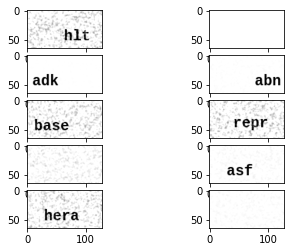

In [10]:
sample_batch = next(iter(trn_dataset))

f, axarr = plt.subplots(5, 2)
for i, ax in enumerate(f.axes):
    # Image is in (W, H, 1) format. Squeeze changes this to (W, H), and .T
    # transposes it to (H, W), allowing it to be displayed as grayscale image
    ax.imshow(np.squeeze(sample_batch[0][i]).T, cmap='gray', vmin=0, vmax=1)

## Preparing the model, optimizer, loss function, and metrics

### Model setup

In [11]:
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
act = 'relu'
conv_to_rnn_dims = (IMG_W // (pool_size ** 2),
                    (IMG_H // (pool_size ** 2)) * conv_filters)

# Input layer
X = layers.Input(shape=(IMG_W, IMG_H, 1), dtype='float32')

# Convolution layers
inner = layers.Conv2D(conv_filters, kernel_size, padding='same',
                      activation=act, kernel_initializer='he_normal',
                      name='conv1')(X)
inner = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = layers.Conv2D(conv_filters, kernel_size, padding='same',
                      activation=act, kernel_initializer='he_normal',
                      name='conv2')(inner)
inner = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
inner = layers.Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
inner = layers.Dense(time_dense_size, activation=act, name='dense1')(inner)

# Recurrent layers: Two layers of bidirectional GRUs
gru_1 = layers.Bidirectional(layers.GRU(rnn_size, return_sequences=True,
                             kernel_initializer='he_normal'),
                             merge_mode='sum', name='bi_gru1')(inner)
gru_2 = layers.Bidirectional(layers.GRU(rnn_size, return_sequences=True,
                             kernel_initializer='he_normal'),
                             merge_mode='concat', name="bi_gru2")(gru_1)

# transforms RNN output to character activations:
inner = layers.Dense(len(ALPHABET)+1, kernel_initializer='he_normal',
                name='dense2')(gru_2)
y_pred = layers.Activation('softmax', name='softmax')(inner)

model = models.Model(inputs=X, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 64, 16)       160       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 32, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 32, 16)        2320      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 32, 16, 16)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 256)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 32)            8224  

### Optimizer

In [12]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9,
                     nesterov=True, clipnorm=5)

### Loss function

In [13]:
def ctc_loss(y, y_pred):
    # Decompose label into its subsequent parts
    input_length = y[:, 0:1]
    label_length = y[:, 1:2]
    y_true = y[:, 2:] 

    # From old example: "the first couple outputs of the RNN tend to be garbage"
    y_pred = y_pred[:, 2:, :]
    
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

### Evaluation metrics

Adapt old functionality to custom Keras metric:

In [14]:
from IPython.core.debugger import set_trace

def edit_distance(y, y_pred):
    # Decompose label into its subsequent parts
    input_length = y[:, 0:1]
    label_length = y[:, 1:2]
    y_true = y[:, 2:]

    # This form is required by ctc_label_dense_to_sparse and ctc_greedy_decoder
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)

    # Get int64 SparseTensor representation of y_true and y_pred
    y_true_sparse = K.ctc_label_dense_to_sparse(y_true, label_length)
    y_true_sparse = tf.cast(y_true_sparse, tf.int64)

    y_pred = tf.transpose(y_pred, [1, 0, 2]) 
    decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(y_pred, input_length)
    y_pred_sparse = decoded[0]

    # Calculate Levenshtein distance for batch
    dist_batch = tf.edit_distance(y_pred_sparse, y_true_sparse)

    return tf.reduce_mean(dist_batch, axis=-1)

## Bringing it all together: the training routine

In [ ]:
model.compile(loss=ctc_loss, optimizer=sgd, metrics=[edit_distance])
model.fit(trn_dataset, batch_size=BATCH_SIZE, epochs=20, shuffle=True,
          validation_data=val_dataset)

Epoch 1/20
480/480 [==============================] - 607s 1s/step - loss: 7.7092 - edit_distance: 0.8125 - val_loss: 2.9763 - val_edit_distance: 0.2208
Epoch 2/20
430/480 [=========================>....] - ETA: 1:01 - loss: 0.5486 - edit_distance: 0.2008